if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = test_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))# Pangyo AI Challenge 2021 - Mask Classification Baseline

## 라이브러리 호출 및 I/O

In [1]:
import os, torch, copy, cv2, sys, random, logging
from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import gc

import matplotlib.pyplot as plt
import json
import pandas as pd
import time

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# # 시드(seed) 설정

# RANDOM_SEED = 2021
# torch.manual_seed(RANDOM_SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(RANDOM_SEED)
# random.seed(RANDOM_SEED)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed = 100
seed_everything(seed)

In [5]:
def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter('%(asctime)s | %(name)s | %(levelname)s | %(message)s')
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

## Argument Setting

In [6]:
# working directory 지정
ROOT_PATH = './'
TRAIN_DIR = os.path.join(ROOT_PATH, 'train')
RESULT_DIR = os.path.join(ROOT_PATH, 'results')
WEIGHT_DIR = os.path.join(ROOT_PATH, 'weights')
NUMPY_DIR = os.path.join(ROOT_PATH, 'numpy')
CSV_DIR = os.path.join(ROOT_PATH, 'csv')
TEST_DIR = os.path.join(ROOT_PATH, 'test')
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

if not os.path.isdir(RESULT_DIR):
    os.makedirs(RESULT_DIR)

# hyper-parameters
EPOCHS = 20
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
INPUT_SHAPE = (180, 90)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [7]:
class CustomDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']

    
def data_loader(data_dir=TRAIN_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db


if os.path.isfile(os.path.join(TRAIN_DIR, 'total.pkl')):
    db = pd.read_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
else:
    db = data_loader()
    db.to_pickle(os.path.join(TRAIN_DIR, 'total.pkl'))
    
    
# Do stratified split
from sklearn.model_selection import train_test_split

train_idx, valid_idx= train_test_split(
    np.arange(len(db)),
    test_size=0.1,
    shuffle=True,
    stratify=db.label.values,
    random_state=seed)

train_db = db.iloc[train_idx]
valid_db = db.iloc[valid_idx]

train_db = train_db.reset_index()
valid_db = valid_db.reset_index()


transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
train_dataset = CustomDataset(db=train_db, mode='train', transform=transform)
validation_dataset = CustomDataset(db=valid_db, mode='val', transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Train set samples: 24388 Val set samples: 2710


## Model

In [9]:
# !pip install git+https://github.com/rwightman/pytorch-image-models.git

In [10]:
import timm

In [11]:
# timm.list_models(pretrained=True)

In [12]:
EFF_BACKBONES = [
    'efficientnet_b1',
    'efficientnet_b1_pruned',
    'tf_efficientnet_b1_ns',
    'tf_efficientnet_b4_ns',
    'tf_efficientnet_b7_ns',
    'efficientnetv2_rw_s',
    'efficientnetv2_rw_m',
    'tf_efficientnetv2_s_in21k',
    'tf_efficientnetv2_s_in21ft1k',
    'tf_efficientnetv2_m_in21k',
    'tf_efficientnetv2_m_in21ft1k',
    'tf_efficientnetv2_l_in21k',
]
NFN_BACKBONES = [
    'eca_nfnet_l0',
    'eca_nfnet_l1',
    'eca_nfnet_l2',
    'dm_nfnet_f2',
    'dm_nfnet_f4',
    'dm_nfnet_f6',
]
    
DEIT_BACKBONES = [
    'deit_base_distilled_patch16_224',
    'deit_base_distilled_patch16_384'   
]  

In [13]:
# # lighter models to experiment on

# EFF_BACKBONES = [
#     'tf_efficientnet_b5_ns',
#     'tf_efficientnet_b6_ns',
#     'tf_efficientnet_b7_ns',
#     'efficientnetv2_rw_s',
#     'efficientnetv2_rw_m',
#     'tf_efficientnetv2_s_in21k',
#     'tf_efficientnetv2_s_in21ft1k',
#     'tf_efficientnetv2_m_in21k',
#     'tf_efficientnetv2_m_in21ft1k'
# ]
# NFN_BACKBONES = [
#     'eca_nfnet_l0',
#     'eca_nfnet_l1',
#     'eca_nfnet_l2'
# ]

In [14]:
from torch.nn import functional as F
# for efficientnet
class EFFMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(EFFMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x


In [15]:
# for nfnet
class NFNMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(NFNMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        n_features = self.model.head.fc.in_features
        self.model.head.fc = nn.Linear(n_features, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

In [16]:
# for deit
class DEITMaskClassifier(nn.Module):
    def __init__(self, backbone):
        super(DEITMaskClassifier, self).__init__()
        self.model = timm.create_model(backbone, pretrained=True)
        in_features_head = self.model.head.in_features
        in_features_head_dist = self.model.head_dist.in_features
        
        self.model.head = nn.Linear(in_features_head, 2)
        self.model.head_dist = nn.Linear(in_features_head_dist, 2)

    def forward(self, input_img):
        x = self.model(input_img)
        return x

## Just Trainer

In [17]:
class Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            pred = F.softmax(pred)

            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)
        

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            pred = F.softmax(pred)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)


## MultiScale Trainer

In [18]:
class MultiScale_Trainer():
    """ Trainer
        epoch에 대한 학습 및 검증 절차 정의
    """
    def __init__(self, criterion, model, device, metric_fn, scales, optimizer=None, scheduler=None, logger=None):
        """ 초기화
        """
        
        self.scales = scales
        self.scales_max_index = len(self.scales) - 1
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차
        """
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            
            img = TF.resize(img, self.scales[np.random.randint(0, self.scales_max_index)])
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            loss = self.criterion(pred, label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, ROC: {auroc}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).long()
            pred = self.model(img)
            ## coordinate loss
            loss = self.criterion(pred, label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, auroc = self.metric_fn(y_pred=pred_lst, y_answer=target_lst, y_prob=prob_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, ROC: {auroc}'
        print(msg)
    


## Metrics

In [19]:
from sklearn.metrics import accuracy_score, roc_auc_score

def get_metric_fn(y_pred, y_answer, y_prob):
    """ 성능을 반환하는 함수
    """
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    auroc = roc_auc_score(y_answer, y_prob)
    return accuracy, auroc

In [20]:
class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        """Taylor Softmax and log are already applied on the logits"""
        #pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.1):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(2, smoothing=smoothing)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

#### Test set Loader

In [21]:
TEST_ANNOT_DIR = os.path.join(ROOT_PATH, 'test_annot')

In [22]:
class CheckDataset(Dataset):
    def __init__(self, db, mode, transform):

        self.db = db
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['label']


In [23]:
def check_loader(data_dir=TEST_ANNOT_DIR):
    print('Loading ' + ' dataset..')
    if not os.path.isdir(data_dir):
        print(f'!!! Cannot find {data_dir}... !!!')
        sys.exit()
        
    mask_image_list = os.listdir(os.path.join(data_dir, 'Mask'))
    nomask_image_list = os.listdir(os.path.join(data_dir, 'NoMask'))
    mask_image_list = [item for item in mask_image_list if item[-4:] == '.png']
    nomask_image_list = [item for item in nomask_image_list  if item[-4:] == '.png']
    mask_image_path = list(map(lambda x : os.path.join(data_dir, 'Mask', x), mask_image_list))
    nomask_image_path = list(map(lambda x : os.path.join(data_dir, 'NoMask', x), nomask_image_list))

    # encoding label (Mask : 1, No Mask : 0)
    mask_df = pd.DataFrame({'img_path':mask_image_path, 'label':np.ones(len(mask_image_list))})
    nomask_df = pd.DataFrame({'img_path':nomask_image_path, 'label':np.zeros(len(nomask_image_list))})
    db = mask_df.append(nomask_df, ignore_index=True)
    return db

In [24]:
if os.path.isfile(os.path.join(TEST_ANNOT_DIR, 'test.pkl')):
    test_db = pd.read_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))
else:
    test_db = check_loader()
    test_db.to_pickle(os.path.join(TEST_ANNOT_DIR, 'test.pkl'))

In [25]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        image_list = os.listdir(self.data_dir)
        image_list = [item for item in image_list if item[-4:] == '.png']
        image_path = list(map(lambda x : os.path.join(self.data_dir, x), image_list))
        db = pd.DataFrame({'img_path':image_path, 'file_num':list(map(lambda x : x.split('.')[0], image_list))})
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_num']

In [26]:
transform = transforms.Compose([
                                transforms.Resize(INPUT_SHAPE),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [27]:
check_dataset = CheckDataset(db=test_db, mode='check', transform=transform)
check_dataloader = DataLoader(check_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
test_dataset = TestDataset(data_dir=TEST_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


# Misc.

In [29]:
def plot_loss(train_loss_history, valid_loss_history, backbone):
    plt.plot(train_loss_history, label="train loss")
    plt.plot(valid_loss_history, label="valid loss")
    plt.legend()
    plt.title(backbone)
    plt.show()

def plot_acc(train_acc_history, valid_acc_history, backbone):
    plt.plot(train_acc_history, label="train acc")
    plt.plot(valid_acc_history, label="valid acc")
    plt.legend()
    plt.title(backbone)
    plt.show()

In [30]:
def wait_and_flush():
    
    print("waiting...")
    
    time.sleep(120)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("flushing...")
    time.sleep(60)
    
    gc.collect()
    torch.cuda.empty_cache()
    print("done!")

In [31]:
def pretty_size(size):

    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

# dump_tensors()

# 학습 Function

In [32]:
def EFF_train_val_infer(BACKBONE):
    model = EFFMaskClassifier(BACKBONE).to(device)
    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None
    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_acc_history, valid_acc_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}

    
    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

In [33]:
def NFN_train_val_infer(BACKBONE):
    model = NFNMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
    criterion = nn.CrossEntropyLoss()
#     criterion = nn.BCEWithLogitsLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = model(img)
            pred = F.softmax(pred)
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())


    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)

    wait_and_flush()

In [34]:
def DEIT_train_val_infer(BACKBONE):
    model = DEITMaskClassifier(BACKBONE).to(device)

    # For Multi-GPU
#     os.environ["CUDA_VISIBLE_DEVICES"] = '0, 1'
#     model = nn.DataParallel(model)

    # Set optimizer, scheduler, loss function, metric function
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=6, T_mult=1, eta_min=1e-6)
    # criterion = TaylorCrossEntropyLoss(n=2, smoothing=0.1)
#     criterion = nn.BCEWithLogitsLoss()
    criterion = nn.CrossEntropyLoss()
    metric_fn = get_metric_fn

    # Set system logger
    system_logger = get_logger(name='train',file_path='train_log.log')

    # Set trainer
    scales = [
        [140, 70], [180, 90], [220, 110], 
        [260, 130], [300, 150], [340, 170],
        [380, 190], [420, 210], [460, 230]
             ]

    trainer = Trainer(criterion, model, device, metric_fn, optimizer, scheduler, logger=system_logger)
    # trainer = MultiScale_Trainer(criterion, model, device, metric_fn, scales, optimizer, scheduler, logger=system_logger)

    train_loss_history = []
    train_acc_history = []

    valid_loss_history = []
    valid_acc_history = []

    best_val_loss = None
    best_val_acc = None

    
    for epoch_index in tqdm(range(EPOCHS)):

        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss_history.append(trainer.train_mean_loss)
        train_acc_history.append(trainer.train_score)

        valid_loss_history.append(trainer.val_mean_loss)
        valid_acc_history.append(trainer.validation_score)

        # don't use early stopper

        if best_val_loss == None or trainer.val_mean_loss < best_val_loss:
            best_val_loss = trainer.val_mean_loss
            criterion = trainer.val_mean_loss
            check_point = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
            }
            torch.save(check_point, os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt'))

    best_val_acc = max(valid_acc_history)

    plot_loss(train_loss_history, valid_loss_history, BACKBONE)
    plot_acc(train_loss_history, valid_loss_history, BACKBONE)
    
    TRAINED_MODEL_PATH = os.path.join(WEIGHT_DIR, f'{BACKBONE}_best.pt')
    
    model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

    # Prediction
    file_num_lst = []
    pred_lst = []
    prob_lst = []
    model.eval()
    with torch.no_grad():
        for batch_index, (img, file_num) in enumerate(test_dataloader):
            img = img.to(device)
            pred = F.softmax(model(img))
            file_num_lst.extend(list(file_num))
            prob_lst.extend(pred[:, 1].cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())

    df = pd.DataFrame({'file_name':list(map(int,file_num_lst)), 'answer':pred_lst, 'prob':prob_lst})
    df.sort_values(by=['file_name'], inplace=True)
    df.to_csv(os.path.join(RESULT_DIR, f'mask_pred_with_{BACKBONE}.csv'), index=False)

    trainer.validate_epoch(check_dataloader, 0)
    
    # save data
    
    TIME = datetime.now().strftime('%m%d%H%M%S')

    save_dict = {'backbone':BACKBONE,
                 'time':TIME,
                 'best_val_loss':best_val_loss,
                 'best_val_acc':best_val_acc,
                 'test_acc':None,
                 'epochs':EPOCHS,
                 'input_shape':INPUT_SHAPE,
                 'augmentation':None,
                 'optimizer':'Adam',
                 'scheduler':'CosineAnnealingWarmRestarts',
                 'attention_module':None,
                 'learning_rate':LEARNING_RATE,
                 'batch_size':BATCH_SIZE,
                 'loss':'CrossEntropyLoss',
                 'freeze':None,
                 'others':None,
                 'randomeseed':seed,
                 'train_loss':train_loss_history,
                 'train_acc':train_acc_history,
                 'valid_loss':valid_loss_history,
                 'valid_acc':valid_acc_history}


    with open(f"{os.path.join(NUMPY_DIR, BACKBONE)}_{TIME}.json", 'w') as f:
        json.dump(save_dict, f)
    
    wait_and_flush()

# 여기서부터 ㄹㅇ 학습save_csv

In [35]:
save_csv = pd.DataFrame()

# Efficient Family

In [36]:
print(len(EFF_BACKBONES))
print(EFF_BACKBONES)

12
['efficientnet_b1', 'efficientnet_b1_pruned', 'tf_efficientnet_b1_ns', 'tf_efficientnet_b4_ns', 'tf_efficientnet_b7_ns', 'efficientnetv2_rw_s', 'efficientnetv2_rw_m', 'tf_efficientnetv2_s_in21k', 'tf_efficientnetv2_s_in21ft1k', 'tf_efficientnetv2_m_in21k', 'tf_efficientnetv2_m_in21ft1k', 'tf_efficientnetv2_l_in21k']


In [37]:
INDEX = 0

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b5_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2874233913216789, Acc: 0.8742414302115795, ROC: 0.9483519941857776
Epoch 0, Val loss: 0.14691389038244032, Acc: 0.9450184501845018, ROC: 0.9884892463200975


  5%|▌         | 1/20 [03:53<1:14:01, 233.76s/it]

Epoch 1, Train loss: 0.08348970122869417, Acc: 0.9704772839101198, ROC: 0.9952890553741249
Epoch 1, Val loss: 0.11242022506407733, Acc: 0.9616236162361623, ROC: 0.9918078877223643


 10%|█         | 2/20 [07:51<1:10:46, 235.93s/it]

Epoch 2, Train loss: 0.03410331578407723, Acc: 0.9879038871576185, ROC: 0.9991691402899068
Epoch 2, Val loss: 0.10958662985115568, Acc: 0.9630996309963099, ROC: 0.9941105957448942


 15%|█▌        | 3/20 [11:46<1:06:45, 235.60s/it]

Epoch 3, Train loss: 0.022351862327728154, Acc: 0.9925373134328358, ROC: 0.9996613397794644


 20%|██        | 4/20 [15:39<1:02:36, 234.80s/it]

Epoch 3, Val loss: 0.12128503238117978, Acc: 0.9690036900369003, ROC: 0.993405628259778
Epoch 4, Train loss: 0.02200964162669837, Acc: 0.9932343775627358, ROC: 0.9995261990766701


 25%|██▌       | 5/20 [19:33<58:37, 234.47s/it]  

Epoch 4, Val loss: 0.11804226117289905, Acc: 0.9664206642066421, ROC: 0.9939305921894062
Epoch 5, Train loss: 0.012158223384750783, Acc: 0.9960226340823356, ROC: 0.9998390366274031


 30%|███       | 6/20 [23:29<54:45, 234.70s/it]

Epoch 5, Val loss: 0.1395871607771568, Acc: 0.9660516605166052, ROC: 0.9935455071837023
Epoch 6, Train loss: 0.015429581524265783, Acc: 0.9950385435460062, ROC: 0.9997973405498648


 35%|███▌      | 7/20 [27:21<50:42, 234.07s/it]

Epoch 6, Val loss: 0.12568290544618993, Acc: 0.9656826568265683, ROC: 0.9945123993470831
Epoch 7, Train loss: 0.011291482241282638, Acc: 0.9964736755781531, ROC: 0.9998633593393008
Epoch 7, Val loss: 0.10947375046009644, Acc: 0.9715867158671587, ROC: 0.994802745639372


 40%|████      | 8/20 [31:03<46:01, 230.17s/it]

Epoch 8, Train loss: 0.010539786755804843, Acc: 0.9966376906675414, ROC: 0.9998701813955516
Epoch 8, Val loss: 0.1091825337859233, Acc: 0.9693726937269372, ROC: 0.9948880104814454


 45%|████▌     | 9/20 [34:45<41:42, 227.50s/it]

Epoch 9, Train loss: 0.009832944775811295, Acc: 0.9968017057569296, ROC: 0.999915431272438


 50%|█████     | 10/20 [38:25<37:32, 225.27s/it]

Epoch 9, Val loss: 0.1248710037637966, Acc: 0.9671586715867159, ROC: 0.9945280033704691
Epoch 10, Train loss: 0.012617240431315997, Acc: 0.9964326718058061, ROC: 0.999791922123947


 55%|█████▌    | 11/20 [42:13<33:56, 226.24s/it]

Epoch 10, Val loss: 0.11830794359114746, Acc: 0.9656826568265683, ROC: 0.9953644904812672
Epoch 11, Train loss: 0.00848532503079118, Acc: 0.9972117434804002, ROC: 0.9999016770712829
Epoch 11, Val loss: 0.08657028180883819, Acc: 0.9771217712177122, ROC: 0.9966217289369369


 60%|██████    | 12/20 [46:48<32:06, 240.81s/it]

Epoch 12, Train loss: 0.00601601491513248, Acc: 0.9981958340167295, ROC: 0.9999742942993921


 65%|██████▌   | 13/20 [51:17<29:05, 249.36s/it]

Epoch 12, Val loss: 0.10586039463185487, Acc: 0.9738007380073801, ROC: 0.9949977959316967
Epoch 13, Train loss: 0.007349738514994061, Acc: 0.997744792520912, ROC: 0.9999121217322902


 70%|███████   | 14/20 [55:50<25:39, 256.55s/it]

Epoch 13, Val loss: 0.14753015723920743, Acc: 0.9690036900369003, ROC: 0.9957924865512824
Epoch 14, Train loss: 0.005005688293717026, Acc: 0.9982368377890766, ROC: 0.9999806725607582


 75%|███████▌  | 15/20 [1:00:19<21:41, 260.25s/it]

Epoch 14, Val loss: 0.1366758367026845, Acc: 0.9704797047970479, ROC: 0.994589304890914
Epoch 15, Train loss: 0.005663070151141519, Acc: 0.9979908151549942, ROC: 0.9999763447005648


 80%|████████  | 16/20 [1:04:50<17:34, 263.74s/it]

Epoch 15, Val loss: 0.15706926677184177, Acc: 0.9723247232472325, ROC: 0.9925078396285351
Epoch 16, Train loss: 0.005517209737252661, Acc: 0.9981548302443825, ROC: 0.9999632235091677


 85%|████████▌ | 17/20 [1:09:26<13:21, 267.29s/it]

Epoch 16, Val loss: 0.13580308855206885, Acc: 0.9734317343173432, ROC: 0.9929670437453223
Epoch 17, Train loss: 0.0075715842454090266, Acc: 0.9979088076103001, ROC: 0.9998404987423336


 90%|█████████ | 18/20 [1:14:13<09:06, 273.16s/it]

Epoch 17, Val loss: 0.12864339780172168, Acc: 0.9756457564575646, ROC: 0.99542802114791
Epoch 18, Train loss: 0.004706375324942441, Acc: 0.9989339019189766, ROC: 0.999968101812629


 95%|█████████▌| 19/20 [1:18:56<04:36, 276.12s/it]

Epoch 18, Val loss: 0.11019613633675228, Acc: 0.9723247232472325, ROC: 0.9958342830424948
Epoch 19, Train loss: 0.004471833200355453, Acc: 0.9986058717402001, ROC: 0.9999791898042054


100%|██████████| 20/20 [1:23:17<00:00, 249.87s/it]

Epoch 19, Val loss: 0.11084495956810417, Acc: 0.9712177121771217, ROC: 0.9951660964696455


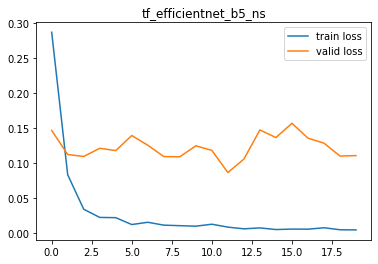

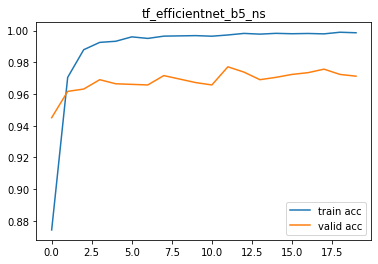

Epoch 0, Val loss: 0.9884394202945259, Acc: 0.8216374269005848, ROC: 0.8946964856230032
waiting...
flushing...
done!


In [38]:
#0
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b6_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b6_ns-51548356.pth" to /home/ys/.cache/torch/hub/checkpoints/tf_efficientnet_b6_ns-51548356.pth
  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3573070679940381, Acc: 0.8397572576677055, ROC: 0.9182517506228886
Epoch 0, Val loss: 0.1916457087286478, Acc: 0.9287822878228782, ROC: 0.9790722182066629


  5%|▌         | 1/20 [05:15<1:39:59, 315.75s/it]

Epoch 1, Train loss: 0.1374503300489193, Acc: 0.9485812694767919, ROC: 0.9878943007461837
Epoch 1, Val loss: 0.16343155346628963, Acc: 0.9376383763837638, ROC: 0.9885633654311811


 10%|█         | 2/20 [10:31<1:34:43, 315.78s/it]

Epoch 2, Train loss: 0.060649253521118406, Acc: 0.9779809742496309, ROC: 0.9974679403263351
Epoch 2, Val loss: 0.15952839789438178, Acc: 0.9583025830258303, ROC: 0.9896539752085505


 15%|█▌        | 3/20 [15:46<1:29:21, 315.40s/it]

Epoch 3, Train loss: 0.0406330462248179, Acc: 0.9872068230277186, ROC: 0.9987785216651579
Epoch 3, Val loss: 0.12961431881278537, Acc: 0.959409594095941, ROC: 0.9918407676287848


 20%|██        | 4/20 [20:59<1:23:51, 314.45s/it]

Epoch 4, Train loss: 0.028350057398572763, Acc: 0.9906101361325242, ROC: 0.9993577359145489
Epoch 4, Val loss: 0.12477372914377721, Acc: 0.9634686346863469, ROC: 0.9923551431139723


 25%|██▌       | 5/20 [26:17<1:18:55, 315.71s/it]

Epoch 5, Train loss: 0.02414334783383086, Acc: 0.9921272757093652, ROC: 0.9995132189363602
Epoch 5, Val loss: 0.113594050051193, Acc: 0.9693726937269372, ROC: 0.9942839118617885


 30%|███       | 6/20 [31:33<1:13:42, 315.92s/it]

Epoch 6, Train loss: 0.021927753869345583, Acc: 0.9927423322945711, ROC: 0.9995598105187121
Epoch 6, Val loss: 0.09705423567774389, Acc: 0.9693726937269372, ROC: 0.9949465255691428


 35%|███▌      | 7/20 [36:52<1:08:37, 316.73s/it]

Epoch 7, Train loss: 0.018012377790846096, Acc: 0.9938904379202886, ROC: 0.9996454801328097


 40%|████      | 8/20 [42:07<1:03:14, 316.24s/it]

Epoch 7, Val loss: 0.1510770380152641, Acc: 0.9642066420664207, ROC: 0.99343683630655
Epoch 8, Train loss: 0.016313996683634154, Acc: 0.9950385435460062, ROC: 0.9997339501270327


 45%|████▌     | 9/20 [47:19<57:46, 315.11s/it]  

Epoch 8, Val loss: 0.1201687313294573, Acc: 0.966789667896679, ROC: 0.9946299868090274
Epoch 9, Train loss: 0.01246465822537909, Acc: 0.9960636378546827, ROC: 0.999853712821032


 50%|█████     | 10/20 [52:35<52:31, 315.12s/it]

Epoch 9, Val loss: 0.12282010040477748, Acc: 0.966789667896679, ROC: 0.9943519008208273
Epoch 10, Train loss: 0.013060009659153488, Acc: 0.9959406265376415, ROC: 0.9998127908043388


 55%|█████▌    | 11/20 [57:37<46:39, 311.08s/it]

Epoch 10, Val loss: 0.1468236706832344, Acc: 0.9653136531365314, ROC: 0.9922358837923796
Epoch 11, Train loss: 0.0129829568843929, Acc: 0.9961456453993768, ROC: 0.999838475863324


 60%|██████    | 12/20 [1:01:47<39:01, 292.63s/it]

Epoch 11, Val loss: 0.11772788181513845, Acc: 0.9678966789667897, ROC: 0.9951672110427444
Epoch 12, Train loss: 0.008943187965782518, Acc: 0.9974167623421355, ROC: 0.9998195922189669


 65%|██████▌   | 13/20 [1:05:57<32:37, 279.67s/it]

Epoch 12, Val loss: 0.13159959079693984, Acc: 0.9653136531365314, ROC: 0.9940492942244493
Epoch 13, Train loss: 0.011736823880343568, Acc: 0.9963916680334591, ROC: 0.9998058655399754


 70%|███████   | 14/20 [1:10:28<27:42, 277.02s/it]

Epoch 13, Val loss: 0.10173860301167019, Acc: 0.9723247232472325, ROC: 0.9955456086098542
Epoch 14, Train loss: 0.0075742254544740786, Acc: 0.9972937510250943, ROC: 0.9999588337241068


 75%|███████▌  | 15/20 [1:15:22<23:30, 282.10s/it]

Epoch 14, Val loss: 0.14061622163692916, Acc: 0.970110701107011, ROC: 0.9939952374291479
Epoch 15, Train loss: 0.008751005065520892, Acc: 0.9968837133016237, ROC: 0.9999288758492548


 80%|████████  | 16/20 [1:20:29<19:18, 289.58s/it]

Epoch 15, Val loss: 0.13161767701670554, Acc: 0.9697416974169741, ROC: 0.9934947941076978
Epoch 16, Train loss: 0.007212745115962541, Acc: 0.9979498113826472, ROC: 0.999902925889447


 85%|████████▌ | 17/20 [1:25:31<14:40, 293.57s/it]

Epoch 16, Val loss: 0.13002220153951186, Acc: 0.9656826568265683, ROC: 0.9938364107625407
Epoch 17, Train loss: 0.0060200562882273346, Acc: 0.9981138264720354, ROC: 0.9999680398877614


 90%|█████████ | 18/20 [1:30:34<09:52, 296.16s/it]

Epoch 17, Val loss: 0.12272933338160527, Acc: 0.966789667896679, ROC: 0.9932601764703588
Epoch 18, Train loss: 0.01069906472934011, Acc: 0.997047728391012, ROC: 0.9998739072084206


 95%|█████████▌| 19/20 [1:35:36<04:58, 298.08s/it]

Epoch 18, Val loss: 0.12489164570708249, Acc: 0.9675276752767528, ROC: 0.9944471968207916
Epoch 19, Train loss: 0.011184778911207447, Acc: 0.9977037887485649, ROC: 0.9998174282888702


100%|██████████| 20/20 [1:40:34<00:00, 301.73s/it]

Epoch 19, Val loss: 0.1143903442412307, Acc: 0.9708487084870848, ROC: 0.9944889933120041


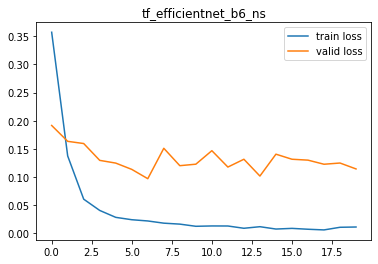

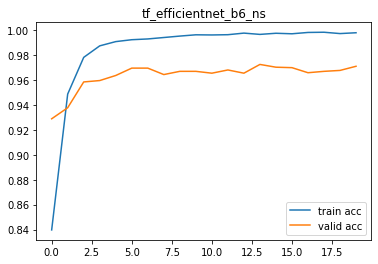

Epoch 0, Val loss: 1.0324405652063433, Acc: 0.8148148148148148, ROC: 0.8852515974440894
waiting...
flushing...
done!


In [39]:
#1
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except: 
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnet_b7_ns    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.3148982953683539, Acc: 0.8622273249138921, ROC: 0.9375799364034363
Epoch 0, Val loss: 0.1793572159715482, Acc: 0.9313653136531366, ROC: 0.9838927468598296


  5%|▌         | 1/20 [06:04<1:55:21, 364.29s/it]

Epoch 1, Train loss: 0.09051066000123625, Acc: 0.9674430047564376, ROC: 0.9946427971347116
Epoch 1, Val loss: 0.11252098270146364, Acc: 0.9619926199261992, ROC: 0.9917415706229739


 10%|█         | 2/20 [12:07<1:49:03, 363.53s/it]

Epoch 2, Train loss: 0.03682111168552548, Acc: 0.9866737739872068, ROC: 0.9990115415017848


 15%|█▌        | 3/20 [18:08<1:42:45, 362.66s/it]

Epoch 2, Val loss: 0.13252879378038662, Acc: 0.9619926199261992, ROC: 0.9900401747873535
Epoch 3, Train loss: 0.02681240916036512, Acc: 0.9909381663113006, ROC: 0.999435926380745


 20%|██        | 4/20 [24:12<1:36:51, 363.21s/it]

Epoch 3, Val loss: 0.11814727919262671, Acc: 0.9642066420664207, ROC: 0.993984091698158
Epoch 4, Train loss: 0.022805745458651598, Acc: 0.9931523700180417, ROC: 0.9994637168852296


 25%|██▌       | 5/20 [30:13<1:30:36, 362.41s/it]

Epoch 4, Val loss: 0.14457545397402277, Acc: 0.9656826568265683, ROC: 0.9921511762368558
Epoch 5, Train loss: 0.014584305509405211, Acc: 0.9944644907331475, ROC: 0.9998174248485999


 30%|███       | 6/20 [36:19<1:24:50, 363.64s/it]

Epoch 5, Val loss: 0.1677725032677807, Acc: 0.962730627306273, ROC: 0.9913598293365671
Epoch 6, Train loss: 0.016169690115584744, Acc: 0.9952435624077415, ROC: 0.9996960211456084


 35%|███▌      | 7/20 [42:20<1:18:35, 362.72s/it]

Epoch 6, Val loss: 0.12470249201104433, Acc: 0.9690036900369003, ROC: 0.9940593253823404
Epoch 7, Train loss: 0.014946833818031836, Acc: 0.9952845661800885, ROC: 0.9997726394082206
Epoch 7, Val loss: 0.10166654678060916, Acc: 0.9738007380073801, ROC: 0.994232084212685


 40%|████      | 8/20 [48:23<1:12:32, 362.70s/it]

Epoch 8, Train loss: 0.01429072903247145, Acc: 0.9965966868951943, ROC: 0.9998324485095413


 45%|████▌     | 9/20 [54:23<1:06:21, 361.94s/it]

Epoch 8, Val loss: 0.11134430282861518, Acc: 0.9719557195571956, ROC: 0.9940743721191768
Epoch 9, Train loss: 0.009551446507250597, Acc: 0.997047728391012, ROC: 0.9999066448217752


 50%|█████     | 10/20 [1:00:27<1:00:25, 362.59s/it]

Epoch 9, Val loss: 0.11589759862205061, Acc: 0.9752767527675277, ROC: 0.9946205129376859
Epoch 10, Train loss: 0.007570010386195064, Acc: 0.9974577661144826, ROC: 0.9999584621749008


 55%|█████▌    | 11/20 [1:05:59<52:58, 353.14s/it]  

Epoch 10, Val loss: 0.11790800179350025, Acc: 0.9745387453874539, ROC: 0.9944070721892277
Epoch 11, Train loss: 0.008658905966485822, Acc: 0.9974167623421355, ROC: 0.999911082770622


 60%|██████    | 12/20 [1:11:01<45:01, 337.64s/it]

Epoch 11, Val loss: 0.12695273083317093, Acc: 0.9756457564575646, ROC: 0.9945898621774635
Epoch 12, Train loss: 0.01074581220314657, Acc: 0.9971707397080531, ROC: 0.9998665725518767
Epoch 12, Val loss: 0.09611746004141816, Acc: 0.9767527675276753, ROC: 0.9952976160953272


 65%|██████▌   | 13/20 [1:16:05<38:12, 327.52s/it]

Epoch 13, Train loss: 0.008058891183251373, Acc: 0.9975397736591767, ROC: 0.9998923195357295


 70%|███████   | 14/20 [1:21:48<33:12, 332.11s/it]

Epoch 13, Val loss: 0.1140148934085296, Acc: 0.9756457564575646, ROC: 0.9952452311596743
Epoch 14, Train loss: 0.007430720429686736, Acc: 0.9978268000656061, ROC: 0.9999393067491803


 75%|███████▌  | 15/20 [1:27:52<28:27, 341.56s/it]

Epoch 14, Val loss: 0.10902184678317642, Acc: 0.974169741697417, ROC: 0.9951438050076655
Epoch 15, Train loss: 0.008859758962659316, Acc: 0.9969657208463178, ROC: 0.9998805262887163


 80%|████████  | 16/20 [1:32:54<21:59, 329.84s/it]

Epoch 15, Val loss: 0.09913865140619958, Acc: 0.9715867158671587, ROC: 0.9950256602591716
Epoch 16, Train loss: 0.006047690639867485, Acc: 0.9981958340167295, ROC: 0.9999405590076148


 85%|████████▌ | 17/20 [1:38:31<16:35, 331.96s/it]

Epoch 16, Val loss: 0.10443903284068423, Acc: 0.9760147601476015, ROC: 0.9962416595101785
Epoch 17, Train loss: 0.006732785551373802, Acc: 0.9980318189273413, ROC: 0.9999395544486508


 90%|█████████ | 18/20 [1:44:51<11:32, 346.21s/it]

Epoch 17, Val loss: 0.12431605325226232, Acc: 0.9730627306273063, ROC: 0.9968334978257465
Epoch 18, Train loss: 0.0060334929392956, Acc: 0.9979498113826472, ROC: 0.9999318895261462


 95%|█████████▌| 19/20 [1:51:01<05:53, 353.47s/it]

Epoch 18, Val loss: 0.09963318494990842, Acc: 0.977490774907749, ROC: 0.9952123512532539
Epoch 19, Train loss: 0.0050186066199739915, Acc: 0.9986878792848942, ROC: 0.9999607774768963


100%|██████████| 20/20 [1:56:02<00:00, 348.11s/it]

Epoch 19, Val loss: 0.11784033477099712, Acc: 0.9771217712177122, ROC: 0.9948367401188914


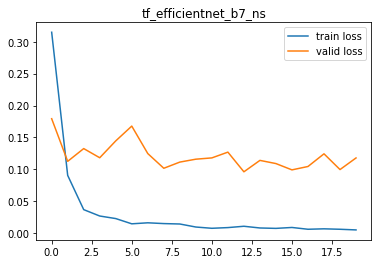

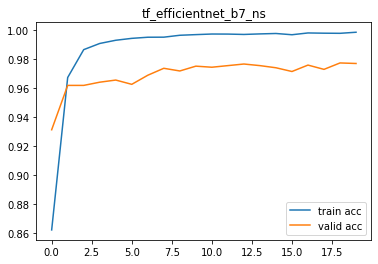

Epoch 0, Val loss: 1.0238653388696548, Acc: 0.8372319688109162, ROC: 0.89551517571885
waiting...
flushing...
done!


In [40]:
#2
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnetv2_rw_s    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.30532566402009703, Acc: 0.8648925701164507, ROC: 0.9420527283092119
Epoch 0, Val loss: 0.19930541747905448, Acc: 0.9354243542435424, ROC: 0.9835054327079278


  5%|▌         | 1/20 [03:26<1:05:18, 206.23s/it]

Epoch 1, Train loss: 0.09544956563373666, Acc: 0.9657208463178613, ROC: 0.9940882771464239


 10%|█         | 2/20 [06:50<1:01:31, 205.10s/it]

Epoch 1, Val loss: 28.039293569217495, Acc: 0.9523985239852398, ROC: 0.9883972940394303
Epoch 2, Train loss: 0.030890717936559488, Acc: 0.9889289814662949, ROC: 0.9993608183968489


 15%|█▌        | 3/20 [10:13<57:50, 204.18s/it]  

Epoch 2, Val loss: 8.141314723147989, Acc: 0.9472324723247233, ROC: 0.9838676689651022
Epoch 3, Train loss: 0.01729002240571201, Acc: 0.9940954567820239, ROC: 0.999796514884963


 20%|██        | 4/20 [13:36<54:19, 203.71s/it]

Epoch 3, Val loss: 0.29191156134938273, Acc: 0.9549815498154982, ROC: 0.9898785616879986
Epoch 4, Train loss: 0.014538350861582672, Acc: 0.9947515171395769, ROC: 0.9998596094445387
Epoch 4, Val loss: 0.14895780112963286, Acc: 0.9601476014760147, ROC: 0.9920982340146532


 25%|██▌       | 5/20 [17:00<50:57, 203.83s/it]

Epoch 5, Train loss: 0.011881877510032201, Acc: 0.9961046416270297, ROC: 0.9998813313119955


 30%|███       | 6/20 [20:23<47:27, 203.41s/it]

Epoch 5, Val loss: 0.5223686409279027, Acc: 0.9649446494464945, ROC: 0.9911603207518465
Epoch 6, Train loss: 0.010564125855637336, Acc: 0.996309660488765, ROC: 0.9998989936603522
Epoch 6, Val loss: 0.13092624432624822, Acc: 0.9653136531365314, ROC: 0.9942744379904471


 35%|███▌      | 7/20 [23:48<44:12, 204.06s/it]

Epoch 7, Train loss: 0.008033134247811836, Acc: 0.9973757585697884, ROC: 0.9998904893118641
Epoch 7, Val loss: 0.1295832773097648, Acc: 0.9690036900369003, ROC: 0.9947475742709717


 40%|████      | 8/20 [27:12<40:49, 204.13s/it]

Epoch 8, Train loss: 0.009544894270683939, Acc: 0.9967196982122355, ROC: 0.999932446849955
Epoch 8, Val loss: 0.11848309260620646, Acc: 0.9708487084870848, ROC: 0.9944076294757772


 45%|████▌     | 9/20 [30:34<37:15, 203.25s/it]

Epoch 9, Train loss: 0.010546099450331086, Acc: 0.9974987698868296, ROC: 0.9999050347752166


 50%|█████     | 10/20 [34:00<34:00, 204.09s/it]

Epoch 9, Val loss: 0.14072643055746914, Acc: 0.9590405904059041, ROC: 0.9939266911835595
Epoch 10, Train loss: 0.005656198253126958, Acc: 0.9980318189273413, ROC: 0.99997443879075


 55%|█████▌    | 11/20 [37:27<30:45, 205.04s/it]

Epoch 10, Val loss: 0.12759258540641577, Acc: 0.9704797047970479, ROC: 0.9953533447502771
Epoch 11, Train loss: 0.008265955947245503, Acc: 0.9969247170739708, ROC: 0.9999363481166157
Epoch 11, Val loss: 0.10380547583532763, Acc: 0.9715867158671587, ROC: 0.9958404131945393


 60%|██████    | 12/20 [40:54<27:25, 205.71s/it]

Epoch 12, Train loss: 0.0043834552362494224, Acc: 0.9986468755125472, ROC: 0.9999815911129613


 65%|██████▌   | 13/20 [44:20<24:00, 205.77s/it]

Epoch 12, Val loss: 0.13930480790104843, Acc: 0.9686346863468634, ROC: 0.9941540640957552
Epoch 13, Train loss: 0.008950737422242084, Acc: 0.9973347547974414, ROC: 0.9999193875834256


 70%|███████   | 14/20 [47:47<20:36, 206.02s/it]

Epoch 13, Val loss: 0.11816139815995129, Acc: 0.9704797047970479, ROC: 0.9952296271362884
Epoch 14, Train loss: 0.005631295249849946, Acc: 0.9980728226996883, ROC: 0.9999662991109267


 75%|███████▌  | 15/20 [51:07<17:02, 204.42s/it]

Epoch 14, Val loss: 0.11730095629959861, Acc: 0.9712177121771217, ROC: 0.9956927322589221
Epoch 15, Train loss: 0.007268634681952066, Acc: 0.9980318189273413, ROC: 0.9999367953517708


 80%|████████  | 16/20 [54:31<13:36, 204.23s/it]

Epoch 15, Val loss: 0.11679896086902854, Acc: 0.9738007380073801, ROC: 0.995130987417027
Epoch 16, Train loss: 0.006287778606916938, Acc: 0.9980728226996883, ROC: 0.9999441781721007


 85%|████████▌ | 17/20 [57:57<10:14, 204.72s/it]

Epoch 16, Val loss: 0.10515687502595147, Acc: 0.9712177121771217, ROC: 0.9950596547386912
Epoch 17, Train loss: 0.0034490605652097548, Acc: 0.9989339019189766, ROC: 0.9999915644569204


 90%|█████████ | 18/20 [1:01:19<06:47, 203.81s/it]

Epoch 17, Val loss: 0.11888906114100366, Acc: 0.9756457564575646, ROC: 0.9953321678613961
Epoch 18, Train loss: 0.00572024602273664, Acc: 0.9982778415614236, ROC: 0.9999503190548075


 95%|█████████▌| 19/20 [1:04:41<03:23, 203.41s/it]

Epoch 18, Val loss: 0.3796593954412915, Acc: 0.9664206642066421, ROC: 0.9937210524467944
Epoch 19, Train loss: 0.0035707376949284343, Acc: 0.9989339019189766, ROC: 0.9999904773314664


100%|██████████| 20/20 [1:08:03<00:00, 204.17s/it]

Epoch 19, Val loss: 0.11184231691511191, Acc: 0.9756457564575646, ROC: 0.9949665878849249


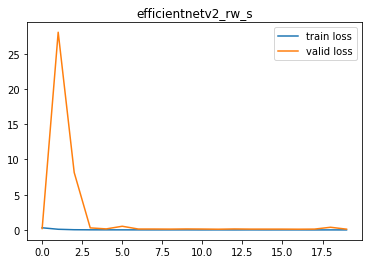

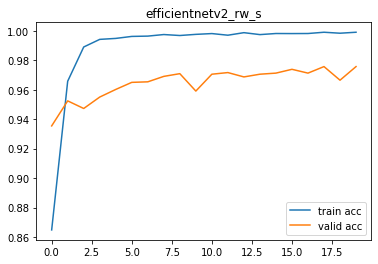

Epoch 0, Val loss: 1.1563525659435072, Acc: 0.8157894736842105, ROC: 0.8869169329073483
waiting...
flushing...
done!


In [41]:
#3
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    efficientnetv2_rw_m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2895963797040205, Acc: 0.8746104641627029, ROC: 0.9479647814287486
Epoch 0, Val loss: 0.15360943125230234, Acc: 0.9464944649446494, ROC: 0.9855679502276238


  5%|▌         | 1/20 [04:55<1:33:29, 295.22s/it]

Epoch 1, Train loss: 0.08080377996599135, Acc: 0.9703132688207315, ROC: 0.9955884311466893
Epoch 1, Val loss: 0.13161250023783003, Acc: 0.9538745387453874, ROC: 0.991360943909666


 10%|█         | 2/20 [09:57<1:29:50, 299.50s/it]

Epoch 2, Train loss: 0.027635744809613196, Acc: 0.9904871248154831, ROC: 0.999388230471587


 15%|█▌        | 3/20 [14:55<1:24:38, 298.71s/it]

Epoch 2, Val loss: 0.1374780414378017, Acc: 0.9535055350553505, ROC: 0.9926036929150489
Epoch 3, Train loss: 0.01796049989157297, Acc: 0.9945464982778416, ROC: 0.9997677748658411
Epoch 3, Val loss: 0.12277155122413168, Acc: 0.9660516605166052, ROC: 0.9930433920026037


 20%|██        | 4/20 [19:54<1:19:38, 298.65s/it]

Epoch 4, Train loss: 0.016036047638360747, Acc: 0.9943414794161063, ROC: 0.9997801667199082
Epoch 4, Val loss: 0.09826909096838962, Acc: 0.9738007380073801, ROC: 0.9957133518612535


 25%|██▌       | 5/20 [24:52<1:14:39, 298.61s/it]

Epoch 5, Train loss: 0.010777391199960382, Acc: 0.9961456453993768, ROC: 0.9999102915084247


 30%|███       | 6/20 [29:45<1:09:13, 296.67s/it]

Epoch 5, Val loss: 0.12133948190152426, Acc: 0.9686346863468634, ROC: 0.9936653237918445
Epoch 6, Train loss: 0.011750760868261538, Acc: 0.995571592586518, ROC: 0.9998925637949297


 35%|███▌      | 7/20 [34:42<1:04:19, 296.88s/it]

Epoch 6, Val loss: 0.14171017663569374, Acc: 0.9630996309963099, ROC: 0.9930567668797917
Epoch 7, Train loss: 0.009453618118185673, Acc: 0.9967607019845826, ROC: 0.9999195251942424


 40%|████      | 8/20 [39:41<59:27, 297.33s/it]  

Epoch 7, Val loss: 0.10216685012090013, Acc: 0.974169741697417, ROC: 0.9953917975221925
Epoch 8, Train loss: 0.007098627482503579, Acc: 0.997744792520912, ROC: 0.9999644207232753


 45%|████▌     | 9/20 [44:34<54:18, 296.24s/it]

Epoch 8, Val loss: 0.11455993633637651, Acc: 0.9738007380073801, ROC: 0.9946389033938193
Epoch 9, Train loss: 0.010540386563607434, Acc: 0.9965146793505002, ROC: 0.9998851672135184


 50%|█████     | 10/20 [49:29<49:16, 295.61s/it]

Epoch 9, Val loss: 0.12443380923616251, Acc: 0.9678966789667897, ROC: 0.9934128729849215
Epoch 10, Train loss: 0.0057220090003951484, Acc: 0.9982368377890766, ROC: 0.9999758011378378


 55%|█████▌    | 11/20 [54:29<44:33, 297.08s/it]

Epoch 10, Val loss: 0.15471370160956954, Acc: 0.9730627306273063, ROC: 0.9938754208210056
Epoch 11, Train loss: 0.00667691868591874, Acc: 0.9979908151549942, ROC: 0.9999564805791368


 60%|██████    | 12/20 [59:24<39:32, 296.51s/it]

Epoch 11, Val loss: 0.11872952916862128, Acc: 0.9712177121771217, ROC: 0.9945408209611075
Epoch 12, Train loss: 0.0072354744338784666, Acc: 0.9979908151549942, ROC: 0.99991861352258


 65%|██████▌   | 13/20 [1:04:18<34:28, 295.57s/it]

Epoch 12, Val loss: 0.11004507044882954, Acc: 0.9738007380073801, ROC: 0.9952781110660949
Epoch 13, Train loss: 0.005839235941543806, Acc: 0.9979908151549942, ROC: 0.9999640870170442


 70%|███████   | 14/20 [1:09:17<29:40, 296.74s/it]

Epoch 13, Val loss: 0.1303709832392577, Acc: 0.9745387453874539, ROC: 0.9943585882594214
Epoch 14, Train loss: 0.007207827919603639, Acc: 0.9975807774315237, ROC: 0.9999512926513374


 75%|███████▌  | 15/20 [1:14:14<24:44, 296.84s/it]

Epoch 14, Val loss: 0.11709037255197537, Acc: 0.9712177121771217, ROC: 0.9946494918382598
Epoch 15, Train loss: 0.006760698865133657, Acc: 0.9980728226996883, ROC: 0.9999488294177139


 80%|████████  | 16/20 [1:19:09<19:45, 296.34s/it]

Epoch 15, Val loss: 0.1172177743153188, Acc: 0.974169741697417, ROC: 0.99601763031728
Epoch 16, Train loss: 0.004606531381592132, Acc: 0.9984828604231589, ROC: 0.9999780029109091


 85%|████████▌ | 17/20 [1:24:07<14:49, 296.63s/it]

Epoch 16, Val loss: 0.10692395910678122, Acc: 0.9763837638376384, ROC: 0.9959719328202211
Epoch 17, Train loss: 0.005937647585374704, Acc: 0.9984828604231589, ROC: 0.9999116228930786


 90%|█████████ | 18/20 [1:29:28<10:08, 304.13s/it]

Epoch 17, Val loss: 0.10387688882616397, Acc: 0.977490774907749, ROC: 0.996244445942926
Epoch 18, Train loss: 0.0029124023088466697, Acc: 0.9993029358701, ROC: 0.9999856884750363


 95%|█████████▌| 19/20 [1:34:22<05:01, 301.12s/it]

Epoch 18, Val loss: 0.13461941652979922, Acc: 0.974169741697417, ROC: 0.9949487547153409
Epoch 19, Train loss: 0.005083086474938107, Acc: 0.998564867967853, ROC: 0.9999226007960015


100%|██████████| 20/20 [1:39:22<00:00, 298.12s/it]

Epoch 19, Val loss: 0.12345709740292848, Acc: 0.9704797047970479, ROC: 0.9941613088208987


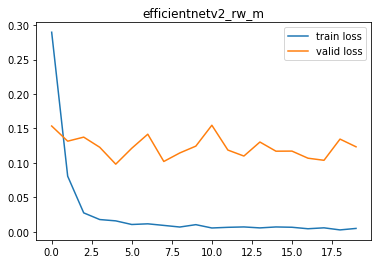

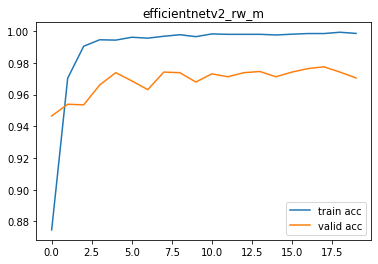

Epoch 0, Val loss: 1.0884923167177476, Acc: 0.8216374269005848, ROC: 0.8854432907348243
waiting...
flushing...
done!


In [42]:
#4
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_s_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.26706026264116794, Acc: 0.8848204034771199, ROC: 0.9556971573155575
Epoch 0, Val loss: 0.11701389241236201, Acc: 0.962730627306273, ROC: 0.9897347817582278


  5%|▌         | 1/20 [03:40<1:09:57, 220.93s/it]

Epoch 1, Train loss: 0.06885602091713454, Acc: 0.9770378874856487, ROC: 0.9968511445628327
Epoch 1, Val loss: 0.08963761077511824, Acc: 0.966789667896679, ROC: 0.9946611948557993


 10%|█         | 2/20 [07:33<1:08:21, 227.86s/it]

Epoch 2, Train loss: 0.02583671635756483, Acc: 0.9916352304412006, ROC: 0.9994966746758913


 15%|█▌        | 3/20 [11:25<1:05:04, 229.70s/it]

Epoch 2, Val loss: 0.1027413688835305, Acc: 0.966789667896679, ROC: 0.9940788304115729
Epoch 3, Train loss: 0.017531040396158108, Acc: 0.994136460554371, ROC: 0.999759820960621


 20%|██        | 4/20 [15:16<1:01:24, 230.29s/it]

Epoch 3, Val loss: 0.10762570378335366, Acc: 0.9645756457564576, ROC: 0.994874078317708
Epoch 4, Train loss: 0.014030765109984996, Acc: 0.9953665737247827, ROC: 0.9998170498591236


 25%|██▌       | 5/20 [19:13<58:08, 232.57s/it]  

Epoch 4, Val loss: 0.11772151993530439, Acc: 0.9660516605166052, ROC: 0.9939055142946787
Epoch 5, Train loss: 0.012838844851074857, Acc: 0.9959816303099885, ROC: 0.9998448162817155


 30%|███       | 6/20 [23:06<54:17, 232.68s/it]

Epoch 5, Val loss: 0.10794687235539162, Acc: 0.9671586715867159, ROC: 0.9949805200486623
Epoch 6, Train loss: 0.010714390414529072, Acc: 0.9965556831228473, ROC: 0.9998370378302869


 35%|███▌      | 7/20 [26:58<50:22, 232.54s/it]

Epoch 6, Val loss: 0.1513620133909704, Acc: 0.9612546125461254, ROC: 0.9938135620140113
Epoch 7, Train loss: 0.00966579937146184, Acc: 0.9968837133016237, ROC: 0.9999002665604091


 40%|████      | 8/20 [30:51<46:31, 232.64s/it]

Epoch 7, Val loss: 0.12287732783447905, Acc: 0.9682656826568266, ROC: 0.9946935174756703
Epoch 8, Train loss: 0.00904216345034898, Acc: 0.9972937510250943, ROC: 0.9998671161146038


 45%|████▌     | 9/20 [34:44<42:39, 232.69s/it]

Epoch 8, Val loss: 0.10631252641592685, Acc: 0.9752767527675277, ROC: 0.9959106312997762
Epoch 9, Train loss: 0.00818381207993942, Acc: 0.9974167623421355, ROC: 0.9999083546361758


 50%|█████     | 10/20 [38:36<38:46, 232.64s/it]

Epoch 9, Val loss: 0.13117275113221527, Acc: 0.9734317343173432, ROC: 0.9951047949492006
Epoch 10, Train loss: 0.007470985789074011, Acc: 0.9980318189273413, ROC: 0.9999302313158018


 55%|█████▌    | 11/20 [42:26<34:44, 231.64s/it]

Epoch 10, Val loss: 0.13999002671613778, Acc: 0.9752767527675277, ROC: 0.995445854317494
Epoch 11, Train loss: 0.007284820863897894, Acc: 0.9973757585697884, ROC: 0.9999493936220634


 60%|██████    | 12/20 [46:17<30:53, 231.67s/it]

Epoch 11, Val loss: 0.13507935406142307, Acc: 0.9715867158671587, ROC: 0.9949292496861084
Epoch 12, Train loss: 0.0072783063350209225, Acc: 0.9978268000656061, ROC: 0.9999505151502216


 65%|██████▌   | 13/20 [50:14<27:12, 233.21s/it]

Epoch 12, Val loss: 0.13119438478071926, Acc: 0.9763837638376384, ROC: 0.994251031955368
Epoch 13, Train loss: 0.0070681632200333975, Acc: 0.9976627849762179, ROC: 0.9999348068754658


 70%|███████   | 14/20 [54:04<23:13, 232.25s/it]

Epoch 13, Val loss: 0.1402783283252876, Acc: 0.9723247232472325, ROC: 0.9940626691016373
Epoch 14, Train loss: 0.006128695771274427, Acc: 0.9981548302443825, ROC: 0.999967200461778


 75%|███████▌  | 15/20 [57:54<19:17, 231.56s/it]

Epoch 14, Val loss: 0.14613857123608068, Acc: 0.9756457564575646, ROC: 0.9943842234406983
Epoch 15, Train loss: 0.005437619468551646, Acc: 0.9984418566508119, ROC: 0.9999456437273013


 80%|████████  | 16/20 [1:01:43<15:23, 230.89s/it]

Epoch 15, Val loss: 0.12327577847499063, Acc: 0.9690036900369003, ROC: 0.9941791419904826
Epoch 16, Train loss: 0.005448018648563059, Acc: 0.9981138264720354, ROC: 0.9999785258320136


 85%|████████▌ | 17/20 [1:05:39<11:36, 232.20s/it]

Epoch 16, Val loss: 0.12773203646175857, Acc: 0.9723247232472325, ROC: 0.9942315269261356
Epoch 17, Train loss: 0.0031796833292670476, Acc: 0.9989339019189766, ROC: 0.9999919084839628


 90%|█████████ | 18/20 [1:09:30<07:43, 231.87s/it]

Epoch 17, Val loss: 0.1769537871349764, Acc: 0.9760147601476015, ROC: 0.9927368844003792
Epoch 18, Train loss: 0.005361634538050743, Acc: 0.9984828604231589, ROC: 0.9999396026124368


 95%|█████████▌| 19/20 [1:13:20<03:51, 231.45s/it]

Epoch 18, Val loss: 0.13726981986689932, Acc: 0.9752767527675277, ROC: 0.9946751270195368
Epoch 19, Train loss: 0.00498695870503679, Acc: 0.9989749056913236, ROC: 0.9999201754053525


100%|██████████| 20/20 [1:17:14<00:00, 231.72s/it]

Epoch 19, Val loss: 0.14157460889831777, Acc: 0.9763837638376384, ROC: 0.9953087618263172


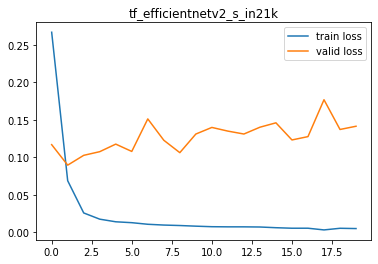

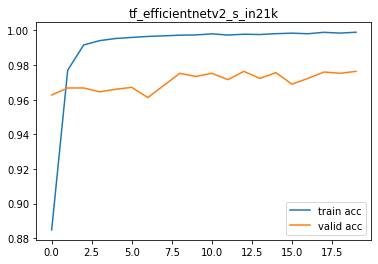

Epoch 0, Val loss: 0.6237397156073712, Acc: 0.8245614035087719, ROC: 0.8987859424920128
waiting...
flushing...
done!


In [43]:
#5
try:
    p
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_s_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2690994963722103, Acc: 0.8830162374938494, ROC: 0.9550191694620239
Epoch 0, Val loss: 0.1369138987756957, Acc: 0.9494464944649447, ROC: 0.9891635630449913


  5%|▌         | 1/20 [03:47<1:12:10, 227.93s/it]

Epoch 1, Train loss: 0.07001862173494847, Acc: 0.9756027554535017, ROC: 0.9967132585242402
Epoch 1, Val loss: 0.10814163018467136, Acc: 0.9638376383763838, ROC: 0.9931559638856023


 10%|█         | 2/20 [07:29<1:07:12, 224.00s/it]

Epoch 2, Train loss: 0.025931142009298955, Acc: 0.9924553058881417, ROC: 0.9994499970867791
Epoch 2, Val loss: 0.09895637870506871, Acc: 0.9675276752767528, ROC: 0.9947135797914521


 15%|█▌        | 3/20 [11:19<1:04:17, 226.89s/it]

Epoch 3, Train loss: 0.01825464988442537, Acc: 0.9939724454649828, ROC: 0.9997701383316224


 20%|██        | 4/20 [15:13<1:01:13, 229.59s/it]

Epoch 3, Val loss: 0.11790847023747539, Acc: 0.9671586715867159, ROC: 0.9934396227392974
Epoch 4, Train loss: 0.01892886365010476, Acc: 0.9934393964244711, ROC: 0.9996654337012689
Epoch 4, Val loss: 0.09449502742704977, Acc: 0.9708487084870848, ROC: 0.9951571798848534


 25%|██▌       | 5/20 [19:04<57:31, 230.09s/it]  

Epoch 5, Train loss: 0.0118492641546022, Acc: 0.9961456453993768, ROC: 0.9998860720046397


 30%|███       | 6/20 [22:57<53:54, 231.06s/it]

Epoch 5, Val loss: 0.10210167615531586, Acc: 0.9686346863468634, ROC: 0.9959474122120431
Epoch 6, Train loss: 0.012980398986086598, Acc: 0.9957356076759062, ROC: 0.9998604282288995


 35%|███▌      | 7/20 [26:47<50:02, 230.94s/it]

Epoch 6, Val loss: 0.13257748890717094, Acc: 0.9675276752767528, ROC: 0.9946985330546158
Epoch 7, Train loss: 0.009681163648271054, Acc: 0.9966376906675414, ROC: 0.9999107628254726


 40%|████      | 8/20 [30:43<46:29, 232.49s/it]

Epoch 7, Val loss: 0.09796598003250914, Acc: 0.9752767527675277, ROC: 0.9964617876972306
Epoch 8, Train loss: 0.009628427977952336, Acc: 0.9965966868951943, ROC: 0.9999257589642507


 45%|████▌     | 9/20 [34:34<42:32, 232.03s/it]

Epoch 8, Val loss: 0.12571307098053924, Acc: 0.9682656826568266, ROC: 0.9943647184114658
Epoch 9, Train loss: 0.008961254097712382, Acc: 0.9968017057569296, ROC: 0.999932625744017
Epoch 9, Val loss: 0.09237290333977834, Acc: 0.9767527675276753, ROC: 0.9961965192996691


 50%|█████     | 10/20 [38:25<38:35, 231.55s/it]

Epoch 10, Train loss: 0.007052849406741753, Acc: 0.9974987698868296, ROC: 0.9999569725378075


 55%|█████▌    | 11/20 [42:18<34:48, 232.02s/it]

Epoch 10, Val loss: 0.1053045963609944, Acc: 0.9767527675276753, ROC: 0.9960131720248839
Epoch 11, Train loss: 0.00878785530221477, Acc: 0.9977037887485649, ROC: 0.9998298545456417


 60%|██████    | 12/20 [46:09<30:54, 231.77s/it]

Epoch 11, Val loss: 0.14617086801494825, Acc: 0.9738007380073801, ROC: 0.9937979579906253
Epoch 12, Train loss: 0.006968123596797182, Acc: 0.997867803837953, ROC: 0.9999014224912716


 65%|██████▌   | 13/20 [50:01<27:03, 231.89s/it]

Epoch 12, Val loss: 0.10475690941317137, Acc: 0.9797047970479705, ROC: 0.99620655045756
Epoch 13, Train loss: 0.006531283198195965, Acc: 0.997785796293259, ROC: 0.9999624150456181


 70%|███████   | 14/20 [53:57<23:18, 233.04s/it]

Epoch 13, Val loss: 0.10836163981216944, Acc: 0.9763837638376384, ROC: 0.9956866021068775
Epoch 14, Train loss: 0.006026070486504916, Acc: 0.9981548302443825, ROC: 0.9999698597908155


 75%|███████▌  | 15/20 [57:26<18:49, 225.86s/it]

Epoch 14, Val loss: 0.09552705808764202, Acc: 0.977490774907749, ROC: 0.9963564605393753
Epoch 15, Train loss: 0.005245255320654283, Acc: 0.9984418566508119, ROC: 0.9999376072555908


 80%|████████  | 16/20 [1:00:55<14:43, 220.83s/it]

Epoch 15, Val loss: 0.1147591334033452, Acc: 0.9767527675276753, ROC: 0.9955227598613249
Epoch 16, Train loss: 0.006103254306500758, Acc: 0.997744792520912, ROC: 0.999911220381439


 85%|████████▌ | 17/20 [1:04:24<10:51, 217.13s/it]

Epoch 16, Val loss: 0.11835005406277904, Acc: 0.977859778597786, ROC: 0.9948701773118614
Epoch 17, Train loss: 0.005621464211463556, Acc: 0.9983188453337707, ROC: 0.9999513752178277


 90%|█████████ | 18/20 [1:07:53<07:09, 214.65s/it]

Epoch 17, Val loss: 0.10377853260014, Acc: 0.9715867158671587, ROC: 0.996047723790953
Epoch 18, Train loss: 0.0038045735975065255, Acc: 0.9989339019189766, ROC: 0.9999731177269071


 95%|█████████▌| 19/20 [1:11:14<03:30, 210.78s/it]

Epoch 18, Val loss: 0.10172782234855554, Acc: 0.977859778597786, ROC: 0.9964718188551216
Epoch 19, Train loss: 0.008941931519371208, Acc: 0.9982778415614236, ROC: 0.9999092456662156
Epoch 19, Val loss: 0.09125039057337976, Acc: 0.9738007380073801, ROC: 0.9970597561648431


100%|██████████| 20/20 [1:14:39<00:00, 223.99s/it]


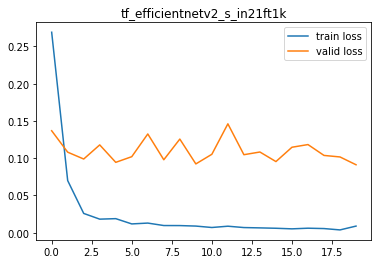

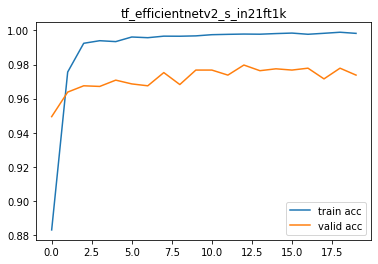

Epoch 0, Val loss: 1.054912937574045, Acc: 0.8323586744639376, ROC: 0.8988378594249201
waiting...
flushing...
done!


In [44]:
#6
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [59]:
gc.collect()
torch.cuda.empty_cache()

In [60]:
INDEX = 7

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.23040451882333737, Acc: 0.9049122519271773, ROC: 0.9672700137250276
Epoch 0, Val loss: 0.0916665866943462, Acc: 0.966789667896679, ROC: 0.9938102182947143


  5%|▌         | 1/20 [05:12<1:39:03, 312.80s/it]

Epoch 1, Train loss: 0.05378244245190967, Acc: 0.9826964080695424, ROC: 0.9978260621566593


 10%|█         | 2/20 [10:30<1:34:38, 315.47s/it]

Epoch 1, Val loss: 0.09506944368645748, Acc: 0.9715867158671587, ROC: 0.9938949258502381
Epoch 2, Train loss: 0.02315388641113654, Acc: 0.9929063473839593, ROC: 0.9995539207757465


 15%|█▌        | 3/20 [15:44<1:29:11, 314.78s/it]

Epoch 2, Val loss: 0.10514493812304045, Acc: 0.9715867158671587, ROC: 0.9941752409846362
Epoch 3, Train loss: 0.024402999474226472, Acc: 0.9932343775627358, ROC: 0.9995413741095099


 20%|██        | 4/20 [20:59<1:23:59, 314.99s/it]

Epoch 3, Val loss: 0.09383790971543887, Acc: 0.9734317343173432, ROC: 0.995733971463585
Epoch 4, Train loss: 0.01715349357192016, Acc: 0.9942184680990651, ROC: 0.9997629481664362


 25%|██▌       | 5/20 [26:13<1:18:41, 314.74s/it]

Epoch 4, Val loss: 0.10809329145046277, Acc: 0.9712177121771217, ROC: 0.9945564249844935
Epoch 5, Train loss: 0.01521569874777084, Acc: 0.9953665737247827, ROC: 0.9997582659583892


 30%|███       | 6/20 [31:26<1:13:17, 314.13s/it]

Epoch 5, Val loss: 0.09574745200986867, Acc: 0.9763837638376384, ROC: 0.9956498211946105
Epoch 6, Train loss: 0.013415080435334664, Acc: 0.9958176152206003, ROC: 0.9998231012947995


 35%|███▌      | 7/20 [36:43<1:08:14, 314.98s/it]

Epoch 6, Val loss: 0.11499588348495028, Acc: 0.9734317343173432, ROC: 0.9948668335925644
Epoch 7, Train loss: 0.01059136049281931, Acc: 0.9965966868951943, ROC: 0.999825158576513


 40%|████      | 8/20 [41:57<1:02:55, 314.66s/it]

Epoch 7, Val loss: 0.10202262118788018, Acc: 0.9686346863468634, ROC: 0.9949554421539348
Epoch 8, Train loss: 0.010187504791173191, Acc: 0.9967196982122355, ROC: 0.9998908677416107
Epoch 8, Val loss: 0.08088731026366626, Acc: 0.9782287822878228, ROC: 0.9965537399778981


 45%|████▌     | 9/20 [47:11<57:38, 314.41s/it]  

Epoch 9, Train loss: 0.008976509305612864, Acc: 0.9971707397080531, ROC: 0.9998558526692356


 50%|█████     | 10/20 [52:27<52:28, 314.87s/it]

Epoch 9, Val loss: 0.0969818012591214, Acc: 0.9785977859778597, ROC: 0.9965247610773241
Epoch 10, Train loss: 0.007530916798072179, Acc: 0.9976627849762179, ROC: 0.9999062251087835


 55%|█████▌    | 11/20 [57:38<47:04, 313.79s/it]

Epoch 10, Val loss: 0.13419255576937064, Acc: 0.9756457564575646, ROC: 0.9931855000727259
Epoch 11, Train loss: 0.010659916575774354, Acc: 0.9967607019845826, ROC: 0.999805521512933


 60%|██████    | 12/20 [1:02:50<41:45, 313.24s/it]

Epoch 11, Val loss: 0.09007899651791937, Acc: 0.9771217712177122, ROC: 0.9956057955572002
Epoch 12, Train loss: 0.005541651132028265, Acc: 0.9982778415614236, ROC: 0.9999761589259618


 65%|██████▌   | 13/20 [1:08:06<36:39, 314.17s/it]

Epoch 12, Val loss: 0.08992585668673297, Acc: 0.977490774907749, ROC: 0.9963481012411328
Epoch 13, Train loss: 0.006917214749407618, Acc: 0.9977037887485649, ROC: 0.9999482996160686


 70%|███████   | 14/20 [1:13:18<31:21, 313.53s/it]

Epoch 13, Val loss: 0.12756079045810248, Acc: 0.9797047970479705, ROC: 0.9947341993937837
Epoch 14, Train loss: 0.006212290413556522, Acc: 0.9980318189273413, ROC: 0.9999538350111807


 75%|███████▌  | 15/20 [1:18:30<26:04, 312.97s/it]

Epoch 14, Val loss: 0.1528338355768636, Acc: 0.9682656826568266, ROC: 0.9948846667621484
Epoch 15, Train loss: 0.006435129814670494, Acc: 0.9981138264720354, ROC: 0.9999262922061665


 80%|████████  | 16/20 [1:23:46<20:54, 313.75s/it]

Epoch 15, Val loss: 0.0920319749183977, Acc: 0.9793357933579335, ROC: 0.9966484786913128
Epoch 16, Train loss: 0.006602643424377331, Acc: 0.9982778415614236, ROC: 0.9998955017858719


 85%|████████▌ | 17/20 [1:28:58<15:40, 313.41s/it]

Epoch 16, Val loss: 0.09033721673918699, Acc: 0.9785977859778597, ROC: 0.9964623449837801
Epoch 17, Train loss: 0.00479275962288336, Acc: 0.9984418566508119, ROC: 0.999983713759813


 90%|█████████ | 18/20 [1:34:15<10:29, 314.55s/it]

Epoch 17, Val loss: 0.1094315813451748, Acc: 0.9756457564575646, ROC: 0.9960544112295469
Epoch 18, Train loss: 0.005019757277130259, Acc: 0.998564867967853, ROC: 0.9999427676612268


 95%|█████████▌| 19/20 [1:39:28<05:14, 314.06s/it]

Epoch 18, Val loss: 0.08642782892026504, Acc: 0.9819188191881919, ROC: 0.9966390048199713
Epoch 19, Train loss: 0.003714175139480895, Acc: 0.9988518943742825, ROC: 0.9999877732789133


100%|██████████| 20/20 [1:44:36<00:00, 313.84s/it]

Epoch 19, Val loss: 0.10329206273798919, Acc: 0.9833948339483395, ROC: 0.9970926360712636


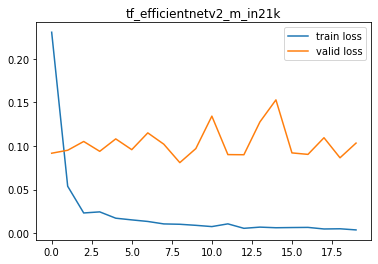

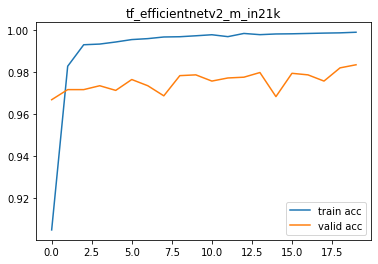

Epoch 0, Val loss: 0.8827640795284424, Acc: 0.8508771929824561, ROC: 0.9136501597444089
waiting...
flushing...
done!


In [61]:
#7
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_m_in21ft1k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.2303688326823645, Acc: 0.9058553386911596, ROC: 0.9674390135693347
Epoch 0, Val loss: 0.11400873232192013, Acc: 0.9560885608856089, ROC: 0.9927586185758096


  5%|▌         | 1/20 [04:43<1:29:43, 283.32s/it]

Epoch 1, Train loss: 0.061543408215178536, Acc: 0.979457110054125, ROC: 0.9972231238024246
Epoch 1, Val loss: 0.09743797951433036, Acc: 0.9634686346863469, ROC: 0.994014185171831


 10%|█         | 2/20 [09:27<1:25:04, 283.61s/it]

Epoch 2, Train loss: 0.026827172735747546, Acc: 0.9913482040347712, ROC: 0.9993945296067334
Epoch 2, Val loss: 0.08296394555379089, Acc: 0.970110701107011, ROC: 0.9957635076507083


 15%|█▌        | 3/20 [14:09<1:20:13, 283.12s/it]

Epoch 3, Train loss: 0.022028883599450946, Acc: 0.9930703624733476, ROC: 0.9995956615768004


 20%|██        | 4/20 [18:50<1:15:17, 282.33s/it]

Epoch 3, Val loss: 0.11076528280432689, Acc: 0.9693726937269372, ROC: 0.9938191348795062
Epoch 4, Train loss: 0.01915666852720837, Acc: 0.9940544530096769, ROC: 0.9996840730864259


 25%|██▌       | 5/20 [23:29<1:10:15, 281.01s/it]

Epoch 4, Val loss: 0.10325843614178483, Acc: 0.9715867158671587, ROC: 0.99511649796674
Epoch 5, Train loss: 0.012637169782378077, Acc: 0.9963506642611121, ROC: 0.9998338555801448


 30%|███       | 6/20 [28:11<1:05:41, 281.51s/it]

Epoch 5, Val loss: 0.10941753287114855, Acc: 0.9726937269372694, ROC: 0.9943223646337038
Epoch 6, Train loss: 0.013608785447029712, Acc: 0.9952845661800885, ROC: 0.9998518069112171


 35%|███▌      | 7/20 [32:49<1:00:41, 280.10s/it]

Epoch 6, Val loss: 0.09094908463674117, Acc: 0.9760147601476015, ROC: 0.9967225978023961
Epoch 7, Train loss: 0.012541033636902585, Acc: 0.9961456453993768, ROC: 0.9998013794273426


 40%|████      | 8/20 [37:27<55:55, 279.60s/it]  

Epoch 7, Val loss: 0.12082750359176848, Acc: 0.9734317343173432, ROC: 0.9956944041185706
Epoch 8, Train loss: 0.00957882395940795, Acc: 0.9968017057569296, ROC: 0.9998647560890929


 45%|████▌     | 9/20 [42:14<51:38, 281.71s/it]

Epoch 8, Val loss: 0.13970277198286404, Acc: 0.9671586715867159, ROC: 0.9936157252889392
Epoch 9, Train loss: 0.010397432277491129, Acc: 0.9963916680334591, ROC: 0.9998726411889046


 50%|█████     | 10/20 [46:57<47:01, 282.13s/it]

Epoch 9, Val loss: 0.09834302893170777, Acc: 0.977490774907749, ROC: 0.9957100081419564
Epoch 10, Train loss: 0.007680272770505691, Acc: 0.9980318189273413, ROC: 0.999843416091653


 55%|█████▌    | 11/20 [51:37<42:14, 281.63s/it]

Epoch 10, Val loss: 0.12689611311217433, Acc: 0.977859778597786, ROC: 0.9936235273006321
Epoch 11, Train loss: 0.00953925294038855, Acc: 0.9968837133016237, ROC: 0.9999120116436366


 60%|██████    | 12/20 [56:19<37:33, 281.68s/it]

Epoch 11, Val loss: 0.08773546637685663, Acc: 0.9730627306273063, ROC: 0.9956364463174227
Epoch 12, Train loss: 0.006611849495836009, Acc: 0.9980318189273413, ROC: 0.9998943596160912


 65%|██████▌   | 13/20 [1:01:13<33:17, 285.41s/it]

Epoch 12, Val loss: 0.1007174348545012, Acc: 0.9730627306273063, ROC: 0.995356688469574
Epoch 13, Train loss: 0.005381651061564521, Acc: 0.9984828604231589, ROC: 0.9999696155316156


 70%|███████   | 14/20 [1:06:24<29:19, 293.19s/it]

Epoch 13, Val loss: 0.12096071581367378, Acc: 0.9749077490774908, ROC: 0.995141018574918
Epoch 14, Train loss: 0.006507446883783504, Acc: 0.9983188453337707, ROC: 0.9999228072122269


 75%|███████▌  | 15/20 [1:11:36<24:54, 298.88s/it]

Epoch 14, Val loss: 0.11154091363921627, Acc: 0.9752767527675277, ROC: 0.9949069582241284
Epoch 15, Train loss: 0.0063452356076958375, Acc: 0.9980728226996883, ROC: 0.9999610458179895


 80%|████████  | 16/20 [1:16:52<20:15, 303.96s/it]

Epoch 15, Val loss: 0.10076925440053323, Acc: 0.9763837638376384, ROC: 0.995651493054259
Epoch 16, Train loss: 0.006093697613636468, Acc: 0.9982778415614236, ROC: 0.9999287898424942


 85%|████████▌ | 17/20 [1:22:04<15:18, 306.30s/it]

Epoch 16, Val loss: 0.11744383634315196, Acc: 0.9704797047970479, ROC: 0.9938091037216155
Epoch 17, Train loss: 0.006259562920250625, Acc: 0.9980728226996883, ROC: 0.9999552627234067


 90%|█████████ | 18/20 [1:27:18<10:17, 308.64s/it]

Epoch 17, Val loss: 0.11964739011480927, Acc: 0.9723247232472325, ROC: 0.9950033687971916
Epoch 18, Train loss: 0.005046494045530821, Acc: 0.9983598491061177, ROC: 0.999926921775654


 95%|█████████▌| 19/20 [1:32:30<05:09, 309.77s/it]

Epoch 18, Val loss: 0.10784607367369337, Acc: 0.9767527675276753, ROC: 0.9965085997673886
Epoch 19, Train loss: 0.004856660999680535, Acc: 0.998564867967853, ROC: 0.9999661855820028


100%|██████████| 20/20 [1:37:43<00:00, 293.16s/it]

Epoch 19, Val loss: 0.08768045336886611, Acc: 0.9793357933579335, ROC: 0.9972837853577418


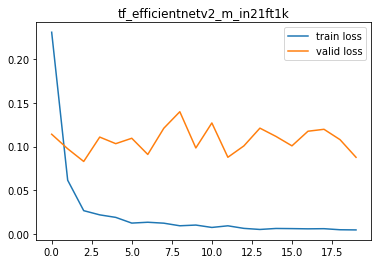

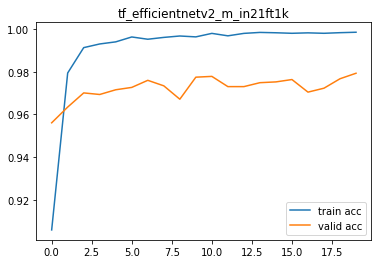

Epoch 0, Val loss: 0.8592105202751554, Acc: 0.8421052631578947, ROC: 0.9017252396166134
waiting...
flushing...
done!


In [62]:
#8
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')   
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [43]:
INDEX = -1

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    tf_efficientnetv2_l_in21k    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.20063631036691612, Acc: 0.9187305232081352, ROC: 0.975004519139229
Epoch 0, Val loss: 0.3628996279112686, Acc: 0.9645756457564576, ROC: 0.9964394962352506


  5%|▌         | 1/20 [07:11<2:16:34, 431.30s/it]

Epoch 1, Train loss: 0.04732825456752706, Acc: 0.9848696080039364, ROC: 0.9982556900077455
Epoch 1, Val loss: 0.3460585538452194, Acc: 0.9738007380073801, ROC: 0.9947353139668828


 10%|█         | 2/20 [14:40<2:12:33, 441.85s/it]

Epoch 2, Train loss: 0.030067997620441746, Acc: 0.9908151549942594, ROC: 0.999175780011825
Epoch 2, Val loss: 0.3404263568347728, Acc: 0.9782287822878228, ROC: 0.9975730170769317


 15%|█▌        | 3/20 [22:04<2:05:27, 442.81s/it]

Epoch 3, Train loss: 0.018084162929031315, Acc: 0.9945875020501886, ROC: 0.9996469663296329
Epoch 3, Val loss: 0.3393964323066395, Acc: 0.9785977859778597, ROC: 0.9963486585276824


 20%|██        | 4/20 [29:37<1:59:11, 446.96s/it]

Epoch 4, Train loss: 0.01553760236640278, Acc: 0.9954895850418238, ROC: 0.9997453890261923
Epoch 4, Val loss: 0.33808096890618816, Acc: 0.9782287822878228, ROC: 0.9975334497319173


 25%|██▌       | 5/20 [37:08<1:52:04, 448.33s/it]

Epoch 5, Train loss: 0.013135296460090881, Acc: 0.995612596358865, ROC: 0.99982343156076


 30%|███       | 6/20 [44:31<1:44:10, 446.48s/it]

Epoch 5, Val loss: 0.3386320378300706, Acc: 0.977859778597786, ROC: 0.9960803250540987
Epoch 6, Train loss: 0.012175873280133294, Acc: 0.996268656716418, ROC: 0.999827350028773
Epoch 6, Val loss: 0.33642779528742006, Acc: 0.9793357933579335, ROC: 0.9961338245628505


 35%|███▌      | 7/20 [52:01<1:37:01, 447.79s/it]

Epoch 7, Train loss: 0.011191054243361547, Acc: 0.9967607019845826, ROC: 0.999787411929421


 40%|████      | 8/20 [58:58<1:27:32, 437.75s/it]

Epoch 7, Val loss: 0.3380976407485601, Acc: 0.9767527675276753, ROC: 0.9967744254514995
Epoch 8, Train loss: 0.007885313987467425, Acc: 0.9976627849762179, ROC: 0.999945155208901


 45%|████▌     | 9/20 [1:06:30<1:21:03, 442.16s/it]

Epoch 8, Val loss: 0.33788366589320484, Acc: 0.9760147601476015, ROC: 0.9952839625748645
Epoch 9, Train loss: 0.010643869182879842, Acc: 0.9972117434804002, ROC: 0.999844974534155
Epoch 9, Val loss: 0.33610656222648166, Acc: 0.977490774907749, ROC: 0.995640347323269


 50%|█████     | 10/20 [1:13:59<1:14:04, 444.40s/it]

Epoch 10, Train loss: 0.007865274201438253, Acc: 0.9970067246186649, ROC: 0.9999539278984823
Epoch 10, Val loss: 0.33464457579618373, Acc: 0.981549815498155, ROC: 0.9970870632057687


 55%|█████▌    | 11/20 [1:21:28<1:06:53, 445.89s/it]

Epoch 11, Train loss: 0.005914080051175708, Acc: 0.9983598491061177, ROC: 0.999944862785915
Epoch 11, Val loss: 0.33310465840898323, Acc: 0.9819188191881919, ROC: 0.9968964712058399


 60%|██████    | 12/20 [1:28:57<59:33, 446.70s/it]  

Epoch 12, Train loss: 0.008412861394433764, Acc: 0.9973757585697884, ROC: 0.9999087709088972


 65%|██████▌   | 13/20 [1:36:28<52:16, 448.03s/it]

Epoch 12, Val loss: 0.3365255823502174, Acc: 0.9782287822878228, ROC: 0.9958228586682302
Epoch 13, Train loss: 0.006359555406151125, Acc: 0.9983188453337707, ROC: 0.9999038857248951


 70%|███████   | 14/20 [1:43:52<44:41, 446.92s/it]

Epoch 13, Val loss: 0.3398420131770817, Acc: 0.9756457564575646, ROC: 0.9962441672996514
Epoch 14, Train loss: 0.005931985926826424, Acc: 0.9981548302443825, ROC: 0.9999627487518494


 75%|███████▌  | 15/20 [1:51:12<37:03, 444.79s/it]

Epoch 14, Val loss: 0.3366320902073877, Acc: 0.9785977859778597, ROC: 0.9960101069488617
Epoch 15, Train loss: 0.006131452051921181, Acc: 0.9981958340167295, ROC: 0.9998321629670962


 80%|████████  | 16/20 [1:58:43<29:46, 446.67s/it]

Epoch 15, Val loss: 0.3377995819029723, Acc: 0.9756457564575646, ROC: 0.9958047468553713
Epoch 16, Train loss: 0.005891730196657199, Acc: 0.9979908151549942, ROC: 0.9999645101703063


 85%|████████▌ | 17/20 [2:06:12<22:21, 447.22s/it]

Epoch 16, Val loss: 0.33474627772026516, Acc: 0.9808118081180812, ROC: 0.9967005849836911
Epoch 17, Train loss: 0.005826303661005862, Acc: 0.9984828604231589, ROC: 0.9998760092136497


 90%|█████████ | 18/20 [2:13:42<14:56, 448.12s/it]

Epoch 17, Val loss: 0.33487788248344286, Acc: 0.9797047970479705, ROC: 0.9972325149951878
Epoch 18, Train loss: 0.00488320950008556, Acc: 0.9984008528784648, ROC: 0.9999761176427169


 95%|█████████▌| 19/20 [2:21:10<07:28, 448.26s/it]

Epoch 18, Val loss: 0.33870795633665907, Acc: 0.9767527675276753, ROC: 0.9969106820128522
Epoch 19, Train loss: 0.004023485104239802, Acc: 0.9990569132360178, ROC: 0.9999826954397674


100%|██████████| 20/20 [2:28:06<00:00, 444.33s/it]

Epoch 19, Val loss: 0.33448195933590275, Acc: 0.981549815498155, ROC: 0.996553739977898


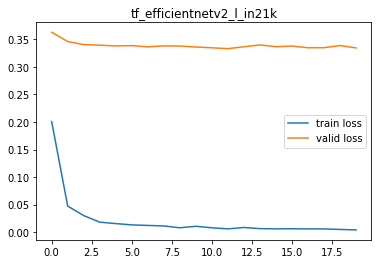

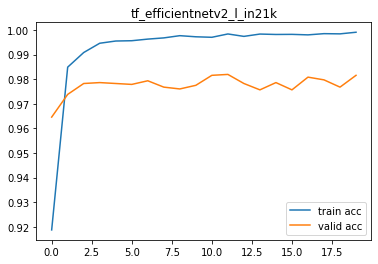

Epoch 0, Val loss: 0.45195469772443175, Acc: 0.8625730994152047, ROC: 0.9191793130990417
waiting...
flushing...
done!


In [44]:
#9
try:
    print(f'\033[48;5;37m\033[38;5;255m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {EFF_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')    
    EFF_train_val_infer(EFF_BACKBONES[INDEX])
except:
    pass
INDEX += 1

# NFNet Family

In [51]:
print(len(NFN_BACKBONES))
print(NFN_BACKBONES)

3
['eca_nfnet_l0', 'eca_nfnet_l1', 'eca_nfnet_l2']


In [52]:
INDEX = 0

In [53]:
print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
NFN_train_val_infer(NFN_BACKBONES[INDEX])

    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    eca_nfnet_l0    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    


  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#0
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#1
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
#2
try:
    print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
    NFN_train_val_infer(NFN_BACKBONES[INDEX])
except:
    pass
INDEX += 1

In [ ]:
# #3
# try:
#     print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
#     NFN_train_val_infer(NFN_BACKBONES[INDEX])
# except:
#     pass
# INDEX += 1

In [ ]:
# #4
# try:
#     print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
#     NFN_train_val_infer(NFN_BACKBONES[INDEX])
# except:
#     pass
# INDEX += 1

In [ ]:
# #5
# try:
#     print(f'\033[48;5;230m\033[38;5;203m    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    {NFN_BACKBONES[INDEX]}    ⸂⸂⸜(രᴗര๑)⸝⸃⸃    \033[0;0m')
#     NFN_train_val_infer(NFN_BACKBONES[INDEX])
# except:
#     pass
# INDEX += 1

# DEIT Couple

In [ ]:
# need to resize image for using this

In [ ]:
DEIT_BACKBONES

In [ ]:
# DEIT_train_val_infer(DEIT_BACKBONES[1])